#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

<!-- You have until midnight of 07/05/23 to submit your mini-projects. You will be requested to upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation:
    - A table with model comparison: linear regression from stimuli, task-driven models (trained and random), data-driven models and your best model
    - A figure showing how the neural prediction changes across layer of a task-driven model
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage on the validation set. -->

In [1]:
import sys
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
#import gdown
#url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
#output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channels (RGB)
The size of the image is 224x224


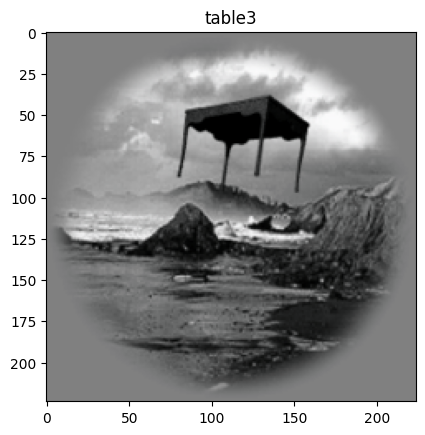

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

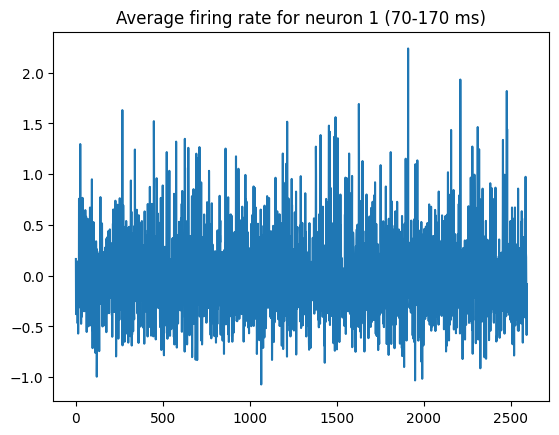

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [7]:
import sklearn.metrics
import sklearn.linear_model

In [8]:
# flatten the RGB channels (n_images, 3, 224, 224) --> (n_images, -1)
stimulus_train_flatten = stimulus_train.reshape(stimulus_train.shape[0], -1)
stimulus_val_flatten = stimulus_val.reshape(stimulus_val.shape[0], -1)

In [9]:
# Linear regression
reg = sklearn.linear_model.LinearRegression()
reg.fit(stimulus_train_flatten, spikes_train)

score_train = reg.score(stimulus_train_flatten, spikes_train)
score_val = reg.score(stimulus_val_flatten, spikes_val)
print(f"score_train: {score_train}, score_val: {score_val}")

score_train: 0.9999999624605598, score_val: -1.1713756168066172


In [14]:
reg_pred_val = reg.predict(stimulus_val_flatten)
mse_reg = sklearn.metrics.mean_squared_error(spikes_val, reg_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(spikes_val, 
                                                                  reg_pred_val, 
                                                                  multioutput='raw_values')
print(mse_reg, np.mean(explained_variance_val))

0.28568867 -1.161680748774892


In [11]:
# Ridge regression
ridge = sklearn.linear_model.Ridge(alpha=1.0)
ridge.fit(stimulus_train_flatten, spikes_train)

score_train = ridge.score(stimulus_train_flatten, spikes_train)
score_val = ridge.score(stimulus_val_flatten, spikes_val)
print(f"score_train: {score_train}, score_val: {score_val}")

/Users/celiabenquet/miniconda3/envs/neuro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.10797e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


score_train: 0.999998843653663, score_val: -1.1671526575315827


In [15]:
ridge_pred_val = ridge.predict(stimulus_val_flatten)
mse_ridge = sklearn.metrics.mean_squared_error(spikes_val, ridge_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(spikes_val, 
                                                                  ridge_pred_val, 
                                                                  multioutput='raw_values')
print(mse_ridge, np.mean(explained_variance_val))

0.28519294 -1.157484049598376


**Interpretation:** For both the linear regression and ridge regression, the model overfits on the training data.

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [11]:
# Compute the predictions for training and validation data from the ridge regression model
pred_train = ridge.predict(stimulus_train_flatten)
pred_val = ridge.predict(stimulus_val_flatten)

**1. Explained variance**

In [12]:
from sklearn.metrics import explained_variance_score

In [13]:
explained_variance_train = explained_variance_score(spikes_train, pred_train, multioutput='raw_values')
explained_variance_val = explained_variance_score(spikes_val, pred_val, multioutput='raw_values')

In [14]:
explained_variance_train.shape

(168,)

In [15]:
print(f"Mean train explained variance: {round(explained_variance_train.mean(), 2)}; "
      f"Standard deviation: {round(explained_variance_train.std(), 4)}\n"
      f"Mean valid explained variance: {round(explained_variance_val.mean(), 2)}; "
      f"Standard deviation: {round(explained_variance_val.std(), 4)}")

Mean train explained variance: 1.0; Standard deviation: 0.0
Mean valid explained variance: -1.16; Standard deviation: 0.3924


Text(0.5, 1.0, 'Validation set')

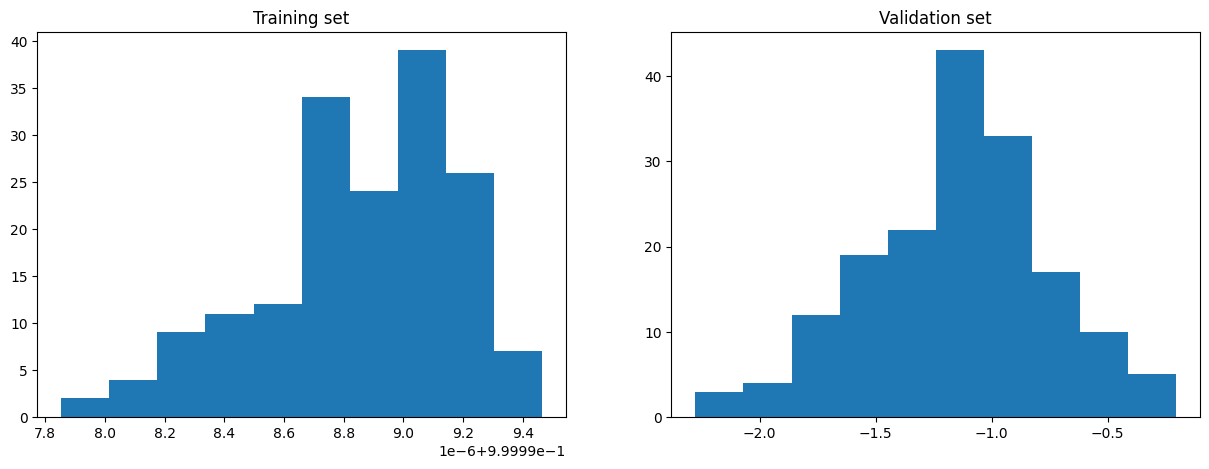

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(explained_variance_train)
axes[0].set_title("Training set")
axes[1].hist(explained_variance_val)
axes[1].set_title("Validation set")

**Interpretation of the explained variance:**

Explained variance is computed using

$ Explained\_Variance = 1− \frac{Variance\_original\_values}{Variance\_errors} $

The distribution of the explained variance score across neurons for the training data is narrow, centered on 1 (higher score) while validation explained variance score is negative, indicating that the model predicts worth than a simple model that would just predict the mean of the target distribution. This confirms that the mode overfitted on the training data and consequently perform poorly on unseen data.


**2. Correlation between neurons**

In [17]:
corr_matrix_train = np.corrcoef(spikes_train, pred_train, rowvar=False)
corr_matrix_val = np.corrcoef(spikes_val, pred_val, rowvar=False)

Text(0.5, 1.0, 'Validation set')

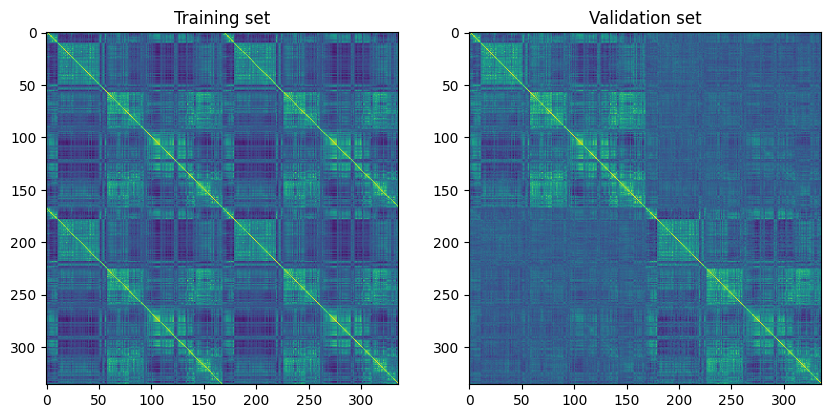

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(corr_matrix_train)
axes[0].set_title("Training set")
axes[1].imshow(corr_matrix_val)
axes[1].set_title("Validation set")

**Interpretation of the correlation matrix:** 

`np.corrcoef` computes the correlation coefficients for every possible pair of columns across both matrices.

- *Top-Left Quarter:* Correlation among the neuron trace.
- *Bottom-Right Quarter:* Correlation among the predicted neuron trace.
- *Top-Right Quarter:* Correlation between each neuron trace and each predicted neuron trace.
- *Bottom-Left Quarter:* Correlation between each neuron trace and each predicted neuron trace. Transpose of the top-right quarter.

For both training and validation data, the autocorrelation (quarters on the diagonals) are similar. However, the neuron trace and predicted neuron trace in the validation data show little to no correlation, once again showing that data overfitted on the training data.

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [16]:
from sklearn.decomposition import PCA

In [17]:
# Compute the 1000 PCs
pca = PCA(n_components=1000)
stimulus_train_pcs = pca.fit_transform(stimulus_train_flatten)
stimulus_val_pcs = pca.transform(stimulus_val_flatten)

In [18]:
reg_pcs = sklearn.linear_model.LinearRegression()
reg_pcs.fit(stimulus_train_pcs, spikes_train)

score_train = reg_pcs.score(stimulus_train_pcs, spikes_train)
score_val = reg_pcs.score(stimulus_val_pcs, spikes_val)
print(f"score_train: {score_train}, score_val: {score_val}")

score_train: 0.4615927092408219, score_val: -0.08824198509378885


In [20]:
reg_pcs_pred_val = reg_pcs.predict(stimulus_val_pcs)
mse_reg_pcs = sklearn.metrics.mean_squared_error(spikes_val, reg_pcs_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(spikes_val, 
                                                                  reg_pcs_pred_val, 
                                                                  multioutput='raw_values')
print(mse_reg_pcs, np.mean(explained_variance_val))

0.14919753 -0.0841945211092631


In [21]:
ridge_pcs = sklearn.linear_model.Ridge()
ridge_pcs.fit(stimulus_train_pcs, spikes_train)

score_train = ridge_pcs.score(stimulus_train_pcs, spikes_train)
score_val = ridge_pcs.score(stimulus_val_pcs, spikes_val)
print(f"score_train: {score_train}, score_val: {score_val}")

score_train: 0.4615927092347461, score_val: -0.0882224296273361


In [22]:
ridge_pcs_pred_val = ridge_pcs.predict(stimulus_val_pcs)
mse_ridge_pcs = sklearn.metrics.mean_squared_error(spikes_val, ridge_pcs_pred_val)
explained_variance_val = sklearn.metrics.explained_variance_score(spikes_val, 
                                                                  ridge_pcs_pred_val, 
                                                                  multioutput='raw_values')
print(mse_ridge_pcs, np.mean(explained_variance_val))

0.14919494 -0.08417499633062453


As a comparison, scores on the linear regression model:
$score\_train: 0.9999999624605598, score\_val: -1.1713756168066172$

and ridge regression model:
$score\_train: 0.999998843653663, score\_val: -1.1671526575315827$

The model seems to overfit less to the training data as the score on the training data is lower and the score on validation data higher, but the score on the validation data is still negative.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [23]:
import sklearn.preprocessing
import sklearn.metrics

In [24]:
alphas = np.logspace(-12, 12, 26)

model = sklearn.linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
model.fit(stimulus_train_pcs, spikes_train)

# Predict on the test set
pred = model.predict(stimulus_val_pcs)

# Calculate the mean squared error
score_train = model.score(stimulus_train_pcs, spikes_train)
score = model.score(stimulus_val_pcs, spikes_val)
mse = sklearn.metrics.mean_squared_error(spikes_val, pred)
print(f"Train R2: {round(score_train, 5)}; Test R2: {round(score, 5)}; "
      f"Test MSE: {round(mse, 5)}; Best alpha: {model.alpha_}")

Train R2: 0.21181; Test R2: 0.08699; Test MSE: 0.12624; Best alpha: 190546.0717963252


**Interpretation:** By finding the best alpha to predict the test data, we can obtain a positive R2 score, still really low, on the validation data but that's also at the expense of the train R2 score.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [25]:
#### Here your code